# Stress inversion on synthetic data sets

You may have to install `pyrocko` [https://pyrocko.org/](https://pyrocko.org/), and `mplstereonet` [https://github.com/joferkington/mplstereonet](https://github.com/joferkington/mplstereonet).

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import sys

# import the iterative linear stress inversion package
import ILSI

import synthetic_dataset as data
from experiment_parameters import *

import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from time import time as give_time

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.colorbar as clb
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mplstereonet

from pyrocko import moment_tensor as pmt

import concurrent.futures
from functools import partial

# set plotting parameters
import seaborn as sns
sns.set(font_scale=1.3)
sns.set_style('ticks')
sns.set_palette('colorblind')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['svg.fonttype'] = 'none'

# define the color palette
_colors_ = ['C0', 'C2', 'C1', 'C4']

## Design the stress tensor, which we will try to retrieve by inverting the (noisy) focal mechanisms

In [2]:
def rotation_x3(theta):
    theta = theta*np.pi/180.
    R3 = np.array([[np.cos(theta), -np.sin(theta), 0.],
                   [np.sin(theta), np.cos(theta), 0.],
                   [0., 0., 1.]])
    return R3

def rotation_x1(theta):
    theta = theta*np.pi/180.
    R1 = np.array([[1., 0., 0.],
                   [0., np.cos(theta), -np.sin(theta)],
                   [0., np.sin(theta), np.cos(theta)]])
    return R1

def design_stress_tensor(exp_number, angle=45., R=None):
    # design stress tensor
    # stress tensor in the (north, west, upward) coordinate system
    # we define a base stress tensor promoting right-lateral
    # strike-slip faulting on E-W faults
    # rotations of this base stress tensor create new stress regimes
    # where the dominant faulting regime is normal, reverse, and a combination
    # of all the above
    sig1 = np.array([-1./np.sqrt(2.), -1./np.sqrt(2.), 0.])
    sig2 = np.array([0., 0., +1.])
    sig3 = np.array([-1./np.sqrt(2.), 1./np.sqrt(2.), 0.])
    basis = np.stack((sig1, sig2, sig3), axis=1)
    if R is None:
        R = 0.50
    if exp_number == 1:
        # SS
        V = basis
    elif exp_number == 2:
        # SS-R
        # rotate the eigenvectors by *angle* degrees about the sig1-axis
        # first, do the rotation in the eigenbasis
        new_eig = rotation_x1(45.).dot(np.identity(3))
        # next, go back to the (north, west, up) basis
        V = basis.dot(new_eig)
    elif exp_number == 3:
        # R
        V = basis.dot(rotation_x1(90.))
    elif exp_number == 4:
        # SS-N
        V = basis.dot(rotation_x3(45.))
    elif exp_number == 5:
        # N
        V = basis.dot(rotation_x3(90.))
    # tension positive
    s1, s2, s3 = -1., 2*R-1., +1.
    S = np.diag(np.array([s1, s2, s3]) - np.sum([s1, s2, s3])/3.)
    S /= np.sqrt(np.sum(S**2))
    stress_tensor = np.dot(V, np.dot(S, V.T))
    return stress_tensor

Choose `st_nb` between 1 and 5. It defines the directions of the principal stresses (see Beauce et al. 2021, Table 1).

In [3]:
st_nb = 1
stress_tensor = design_stress_tensor(st_nb, R=0.50)
true_stress_tensor = stress_tensor # alias
# fix the number of data
n_earthquakes = 250
# plot azimuth/plunge of principal stresses
p_sig, p_dir = ILSI.utils_stress.stress_tensor_eigendecomposition(stress_tensor)
for i in range(3):
    print(f'Azimuth and plunge of principal direction {i+1}: ', ILSI.utils_stress.get_bearing_plunge(p_dir[:, i]))

Azimuth and plunge of principal direction 1:  (315.0, 0.0)
Azimuth and plunge of principal direction 2:  (180.0, 90.0)
Azimuth and plunge of principal direction 3:  (45.0, 0.0)


## Fault planes verifying the Mohr-Coulomb failure criterion (Vavrycuk)

Choose `exp_label` between 1 and 6. It defines the data scenario as defined in Beauce et al. 2021, Table 2.

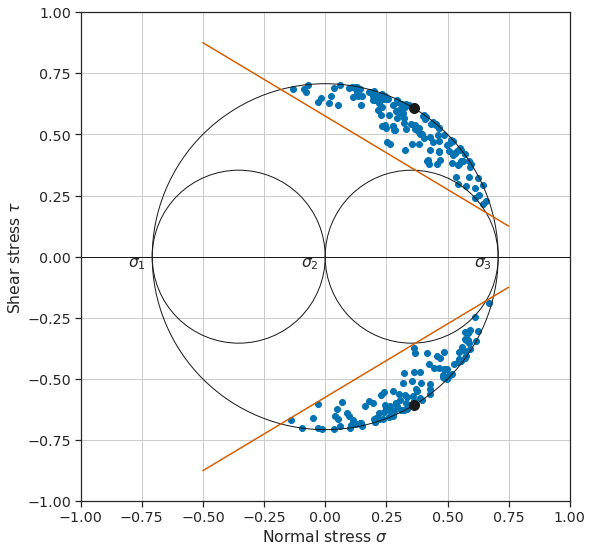

In [4]:
exp_label = 1 # the average friction is different from the assumed friction in the computation of I
# all experiment parameters are defined in experiment_parameters.py
mu = exp_params[exp_label]['mu']
min_instability = exp_params[exp_label]['min_instability']
# if the resolved shear stress on the randomly generated fault plane is below the Mohr-Coulomb failure criterion,
# the fault plane is kept with probability no higher than max_acceptance_p, and decreasing probability
# according to I
max_acceptance_p = exp_params[exp_label]['max_acceptance_p']
random_comp_friction = exp_params[exp_label]['random_comp_friction']
strikes, dips, fig_Mohr = data.random_data_failure(
    n_earthquakes, stress_tensor, mu, min_instability,
    max_acceptance_probability=max_acceptance_p,
    random_friction=random_comp_friction,
    naive_uniform=False)
#fig_Mohr.savefig(fig_Mohr._label + '.svg', format='svg', bbox_inches='tight')

## Compute slip vectors according to the Wallace-Bott assumption

In [5]:
# first, compute the fault normals
n, _ = ILSI.utils_stress.normal_slip_vectors(strikes, dips, np.zeros_like(strikes))
traction, normal_traction, shear_traction = \
        ILSI.utils_stress.compute_traction(true_stress_tensor, n.T)
shear_dir = shear_traction/np.sqrt(np.sum(shear_traction**2, axis=-1, keepdims=True))
# find the rake that will make slip in the same direction as shear
s, d, rakes = np.asarray(list(map(ILSI.utils_stress.strike_dip_rake, n.T, shear_dir))).T
print(np.allclose(s, strikes, atol=1.e-3), np.allclose(d, dips, atol=1.e-3))

True True


[285.48187827] [90.]
[164.51812173] [90.]


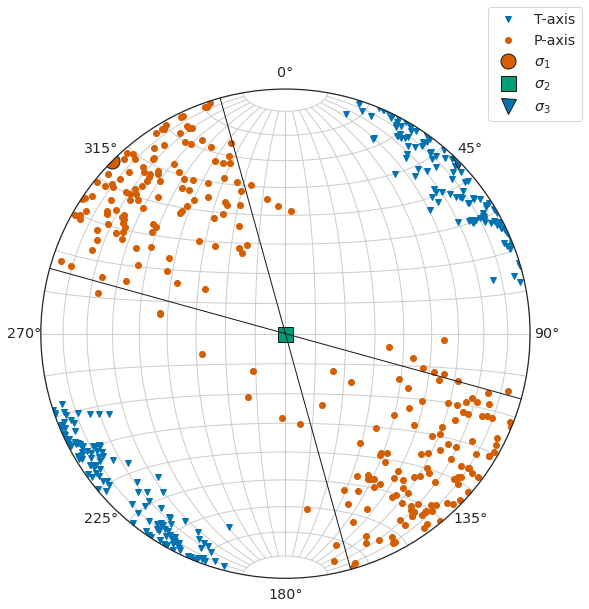

In [6]:
# plot P/T axes
fig_PT = data.plot_dataset_PT(
    strikes, dips, rakes, stress_tensor=stress_tensor, figname='')
# add the principal faults
n1, n2 = ILSI.utils_stress.principal_faults(stress_tensor, mu)
s1, d1, _ = ILSI.utils_stress.strike_dip_rake(n1, np.zeros(3))
s2, d2, _ = ILSI.utils_stress.strike_dip_rake(n2, np.zeros(3))
print(s1, d1)
print(s2, d2)
ax = fig_PT.get_axes()[1]
ax.plane(s1, d1, lw=1.0, color='k')
ax.plane(s2, d2, lw=1.0, color='k')
plt.show()

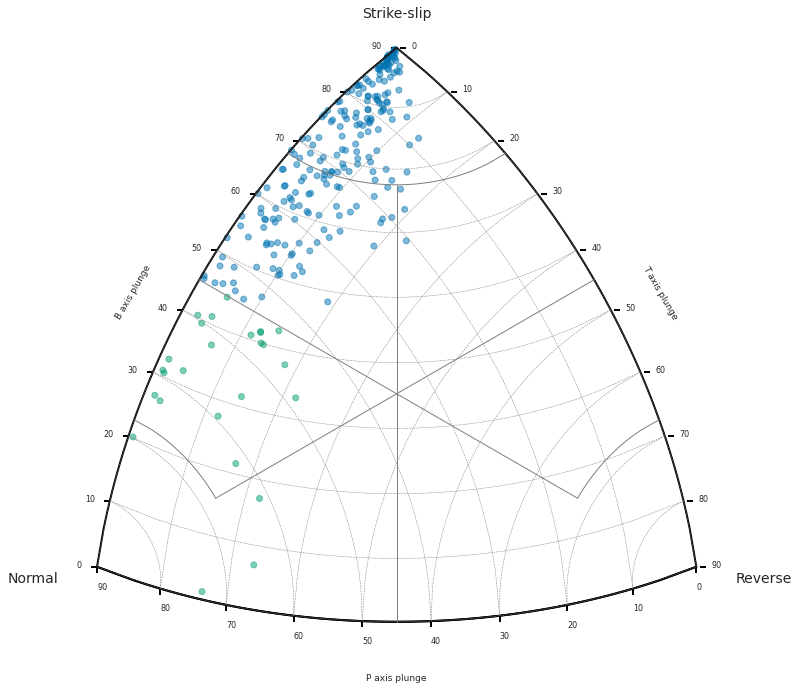

In [7]:
# See https://josealvarezgomez.wordpress.com/2014/04/22/fmc-a-python-program-to-manage-classify-and-plot-focal-mechanism-data/ to build the Kaverina diagram.
# # plot data in Kaverina diagram
# sys.path.append(os.path.join('/home/eric/Dropbox (MIT)/DANA/temporary_working_dir/focal_mechanisms/FMC/'))
# import plotFMC
# import functionsFMC
# from functionsFMC import kave, mecclass

# # determine the t and p axes
# P_axis = np.zeros((n_earthquakes, 2), dtype=np.float32)
# T_axis = np.zeros((n_earthquakes, 2), dtype=np.float32)
# B_axis = np.zeros((n_earthquakes, 2), dtype=np.float32)
# faulting_type = np.zeros(n_earthquakes, dtype=np.int32)
# fm_type = []
# r2d = 180./np.pi
# for t in range(n_earthquakes):
#     # first, get normal and slip vectors from
#     # strike, dip, rake
#     normal, slip = ILSI.utils_stress.normal_slip_vectors(strikes[t], dips[t], rakes[t])
#     # second, get the t and p vectors
#     p_axis, t_axis, b_axis =\
#             ILSI.utils_stress.p_t_b_axes(normal, slip)
#     p_bearing, p_plunge = ILSI.utils_stress.get_bearing_plunge(p_axis)
#     t_bearing, t_plunge = ILSI.utils_stress.get_bearing_plunge(t_axis)
#     b_bearing, b_plunge = ILSI.utils_stress.get_bearing_plunge(b_axis)
#     P_axis[t, :] = p_bearing, p_plunge
#     T_axis[t, :] = t_bearing, t_plunge
#     B_axis[t, :] = b_bearing, b_plunge
#     fm_type.append(mecclass(t_plunge, b_plunge, p_plunge))
# # get the x, y coordinates for FMC's plots
# x_kave, y_kave = kave(T_axis[:, 1], B_axis[:, 1], P_axis[:, 1])

# colors_fm = {}
# colors_fm['SS'] = 'C0'
# colors_fm['SS-N'] = 'C0'
# colors_fm['SS-R'] = 'C0'
# colors_fm['R'] = 'C1'
# colors_fm['R-SS'] = 'C1'
# colors_fm['N'] = 'C2'
# colors_fm['N-SS'] = 'C2'
# colors = np.asarray([colors_fm[fm] for fm in fm_type])


# fig_Kav = plt.figure('Kaverina_diagram', figsize=(12, 12))
# ax = fig_Kav.add_subplot(111)
# fig_Kav = plotFMC.baseplot(10, '', ax=ax)
# ax.scatter(x_kave, y_kave, color=colors, alpha=0.5)

285.481878266 90.0 180.0
164.518121734 90.0 0.0 0.0


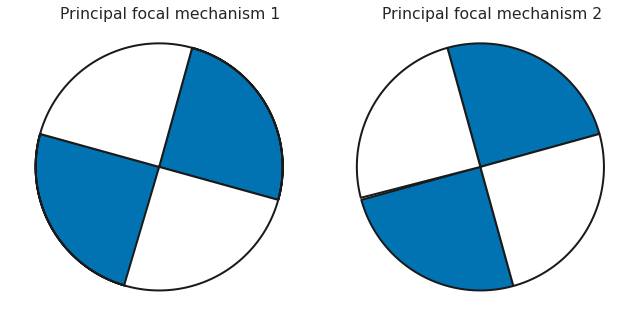

In [8]:
# plot principal focal mechanisms
# 1) get the fault normals
n1, n2 = ILSI.utils_stress.principal_faults(stress_tensor, mu)
# 2) get the direction maximum shear on these planes
T1, Tn1, Ts1 = ILSI.utils_stress.compute_traction(stress_tensor, n1.T)
T2, Tn2, Ts2 = ILSI.utils_stress.compute_traction(stress_tensor, n2.T)
# 3) take the slip vector as the unitary vector along the maximum shear
s1 = Ts1/np.linalg.norm(Ts1, 2)
s2 = Ts2/np.linalg.norm(Ts2, 2)
# 4) convert the normal and slip vectors to strike/dip/rake
strike1, dip1, rake1 = ILSI.utils_stress.strike_dip_rake(n1.squeeze(), s1.squeeze())
strike2, dip2, rake2 = ILSI.utils_stress.strike_dip_rake(n2.squeeze(), s2.squeeze())
# plot
from obspy.imaging.beachball import beach
bb1 = beach([strike1, dip1, rake1], facecolor='C0', xy=(0., 0.), width=1.)
bb2 = beach([strike2, dip2, rake2], facecolor='C0', xy=(1.3, 0.), width=1.)
print(strike1, dip1, rake1)
print(strike2, dip2, rake2, n2[2, 0])
fig, ax = plt.subplots(num='principal_focal_mechanisms', figsize=(12, 5))
ax.add_collection(bb1)
ax.add_collection(bb2)
ax.text(-0.4, 0.6, 'Principal focal mechanism 1')
ax.text(0.9, 0.6, 'Principal focal mechanism 2')
ax.axis('off')
ax.autoscale_view(tight=False)
ax.set_aspect('equal')
fig.savefig(f'{fig._label}_st{st_nb}' + '.png', format='png', bbox_inches='tight')
fig.savefig(f'{fig._label}_st{st_nb}' + '.svg', format='svg', bbox_inches='tight')

## Compute the (normalized) moment tensors from the strikes/dips/rakes

The addition of noise will be conducted directly on the moment tensors, by rotated them about a randomly chosen axis, and a randomly chosen rotation angle (but with controlled max value, larger max angle means more noise).

In [9]:
mt0 = []
for i in range(n_earthquakes):
    mt0_ = pmt.as_mt([strikes[i], dips[i], rakes[i]])
    # normalize it so that we don't deal with tiny numerical values
    mt0_ = pmt.as_mt(mt0_.m()/np.sqrt(np.sum(mt0_.m()**2)))
    mt0.append(mt0_)

## Loop through many levels of noise

In [ ]:
# eigendecomposition of the true stress tensor
true_p_sig, true_p_dir = ILSI.utils_stress.stress_tensor_eigendecomposition(
            true_stress_tensor)
true_R = ILSI.utils_stress.R_(true_p_sig)
# true shear stresses (directions and magnitudes)
true_n, _ = ILSI.utils_stress.normal_slip_vectors(strikes, dips, np.zeros_like(strikes))
true_traction, true_normal_traction, true_shear_traction = \
        ILSI.utils_stress.compute_traction(true_stress_tensor, true_n.T)
true_shear_mag = np.sqrt(np.sum(shear_traction**2, axis=-1))
true_shear_dir = true_shear_traction/true_shear_mag[..., np.newaxis]
# true strikes, dips, rakes
true_strikes = strikes.copy()
true_dips = dips.copy()
true_rakes = rakes.copy()

In [ ]:
# define the functions to quantify error of the inverted solutions
def inner_prod(x, y):
    # need to clip the inner product, or numerical imprecisions can produce
    # values slightly larger than +1 or slightly smaller than -1, which
    # gives NaN in arccos
    return np.clip(np.sum(x*y, axis=-1), -1, +1)

def mean_stress_angle(true_p_directions, inv_p_directions):
    angles = np.zeros(3, dtype=np.float32)
    for i in range(3):
        # switch the direction of one vector and look for the smallest angle
        cos_i = np.array([inner_prod(true_p_directions[:, i], inv_p_directions[:, i]),
                          inner_prod(-true_p_directions[:, i], inv_p_directions[:, i])])
        angles[i] = np.min(np.abs(np.arccos(cos_i)))
    mean_angle = np.mean(np.abs(angles))
    return mean_angle*180./np.pi

def shape_ratio_error(true_R, inv_R):
    return abs(true_R - inv_R)
    #return abs(true_R - inv_R)/true_R

def shear_error(true_shear_dir, true_shear_mag, inv_stress_tensor):
    traction, normal_traction, shear_traction = \
            ILSI.utils_stress.compute_traction(inv_stress_tensor, true_n.T)
    inv_shear_mag = np.sqrt(np.sum(shear_traction**2, axis=-1))
    inv_shear_dir = shear_traction/inv_shear_mag[..., np.newaxis]
    mag_error = np.mean(np.abs(true_shear_mag - inv_shear_mag)/true_shear_mag)

    dir_error = np.mean(np.abs(np.arccos(inner_prod(true_shear_dir, inv_shear_dir))))
    return mag_error, dir_error*180./np.pi

def perturb_moment_tensors(mt0, max_rotation_angle):
    strikes_n, dips_n, rakes_n = np.zeros((3, len(mt0)), dtype=np.float32)
    for i in range(len(mt0)):
        # generate random rotation matrix
        R_random = ILSI.utils_stress.random_rotation(
            max_angle=max_rotation_angle)
        # rotate the moment tensor
        mt_noisy = pmt.as_mt(R_random.dot(mt0[i].m().dot(R_random.T)))
        strikes_n[i], dips_n[i], rakes_n[i] = \
            mt_noisy.strike1, mt_noisy.dip1, mt_noisy.rake1
    return strikes_n, dips_n, rakes_n

In [ ]:
# inversion parameters
friction_min = 0.1
friction_max = 1.1
friction_step = 0.05
n_random_selections = 20
n_stress_iter = 10
n_averaging_ILSI = 1
n_exp_per_noise = 30
#n_resamplings = 1000
ILSI_kwargs = {}
ILSI_kwargs['max_n_iterations'] = 300
ILSI_kwargs['shear_update_atol'] = 1.e-5
Tarantola_kwargs0 = {}
inversion_output = {}
methods = ['constant_shear', 'variable_shear']

In [ ]:
# define routine to run sub-experiment to easily distribute
# several sub-experiments accross multiple cores
# the following function should be adequate for multi-threading:
def run_subexperiment(dataset_size, max_rotation_angle, n_exp_per_noise):
    #print(f'Size of the data set: {dataset_size}')
    averaged_results = {}
    # repeat the experiment several times for a given noise level
    # and dataset size to mitigate the effect of pathological datasets
    subexp_output = {}
    for method in methods:
        averaged_results[method] = {}
        subexp_output[method] = {}
        for item in ['stress_dir', 'shape_ratio', 'shear_mag',
                     'shear_dir', 'friction']:
            subexp_output[method][item] = np.zeros(n_exp_per_noise, dtype=np.float32)
        subexp_output[method]['stress_tensor'] = np.zeros((n_exp_per_noise, 3, 3), dtype=np.float32)
    for i_noise in range(n_exp_per_noise):
        subset = np.random.choice(
            np.arange(len(true_strikes)), dataset_size, replace=False)
        mt0_subset = [mt0[i_sub] for i_sub in subset]
        strikes_1n, dips_1n, rakes_1n = perturb_moment_tensors(
            mt0_subset, max_rotation_angle=max_rotation_angle)
        # invert
        for method in methods:
            if method == 'constant_shear':
                variable_shear = False
            else:
                variable_shear = True
            subexp_output[method]['stress_tensor'][i_noise, ...],\
            subexp_output[method]['friction'][i_noise], p_stresses, p_dir =\
                    ILSI.ilsi.inversion_one_set_instability(
                            strikes_1n, dips_1n, rakes_1n,
                            n_random_selections=n_random_selections,
                            **ILSI_kwargs,
                            Tarantola_kwargs=Tarantola_kwargs0.copy(),
                            friction_min=friction_min,
                            friction_max=friction_max,
                            friction_step=friction_step,
                            n_stress_iter=n_stress_iter,
                            n_averaging=n_averaging_ILSI,
                            weighted=False,
                            variable_shear=variable_shear, verbose=1)
            # compute errors
            subexp_output[method]['stress_dir'][i_noise] = ILSI.utils_stress.kagan_angle(
                true_stress_tensor, subexp_output[method]['stress_tensor'][i_noise, ...])
            #subexp_output[method]['stress_dir'][i_noise] = mean_stress_angle(true_p_dir, p_dir)
            subexp_output[method]['shape_ratio'][i_noise] = shape_ratio_error(
                true_R, ILSI.utils_stress.R_(p_stresses))
            subexp_output[method]['shear_mag'][i_noise], subexp_output[method]['shear_dir'][i_noise]  = shear_error(
                true_shear_dir, true_shear_mag, subexp_output[method]['stress_tensor'][i_noise, ...])
    # average the results over the n_exp_per_noise experiments
    for method in methods:
        averaged_results[method]['stress_tensor'] = \
            np.mean(subexp_output[method]['stress_tensor'], axis=0)
        averaged_results[method]['stress_dir'] = np.mean(subexp_output[method]['stress_dir'])
        averaged_results[method]['shape_ratio'] = np.mean(subexp_output[method]['shape_ratio'])
        averaged_results[method]['shear_mag'] = np.mean(subexp_output[method]['shear_mag'])
        averaged_results[method]['shear_dir'] = np.mean(subexp_output[method]['shear_dir'])
    return averaged_results

In [ ]:
t_start = give_time()
n_noise = 30
max_rotation = np.linspace(0., 60., n_noise) # in degrees
dataset_sizes = np.arange(50, 251, 25)
n_datasets = len(dataset_sizes)
errors = {}
for method in methods:
    errors[method] = {}
    inversion_output[method] = {}
    errors[method]['stress_dir'] = np.zeros((n_noise, n_datasets), dtype=np.float32)
    errors[method]['shape_ratio'] = np.zeros((n_noise, n_datasets), dtype=np.float32)
    errors[method]['shear_mag'] = np.zeros((n_noise, n_datasets), dtype=np.float32)
    errors[method]['shear_dir'] = np.zeros((n_noise, n_datasets), dtype=np.float32)
    inversion_output[method]['friction'] = np.zeros((n_noise, n_datasets), dtype=np.float32)
    inversion_output[method]['stress_tensor'] = np.zeros((n_noise, n_datasets, 3, 3), dtype=np.float32)
#for n1 in range(n_noise):
for n1 in [0]:
    print(f'------- {n1+1}/{n_noise} -------')
    with concurrent.futures.ProcessPoolExecutor() as executor:
        run_sub = partial(
            run_subexperiment, max_rotation_angle=max_rotation[n1], n_exp_per_noise=n_exp_per_noise)
        results = list(executor.map(run_sub, dataset_sizes))
    for n2 in range(n_datasets):
        for method in methods:
            inversion_output[method]['stress_tensor'][n1, n2, ...] = \
                results[n2][method]['stress_tensor']
            errors[method]['stress_dir'][n1, n2] = results[n2][method]['stress_dir']
            errors[method]['shape_ratio'][n1, n2] = results[n2][method]['shape_ratio']
            errors[method]['shear_mag'][n1, n2] = results[n2][method]['shear_mag']
            errors[method]['shear_dir'][n1, n2] = results[n2][method]['shear_dir']          
t_end = give_time()
print('{:.2f}sec to run the experiment.'.format(t_end-t_start))

In [ ]:
# plot the errors
def plot_errors(errors, dataset_sizes, noise_levels, figname='', title=''):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, axes = plt.subplots(num=f'errors{figname}', ncols=2, nrows=2, figsize=(12, 12))
    fig.suptitle(title)
    cmap = 'inferno'
    #clb_labels = ['Mean stress dir. error ('u'\u00b0'')', 'Shape ratio error',
    #              'Mean shear dir. error ('u'\u00b0'')', 'Mean shear mag. error (%)']
    clb_labels = ['Stress tensor diff. (Kagan angle,'u'\u00b0'')', 'Shape ratio error',
                  'Mean shear dir. error ('u'\u00b0'')', 'Mean shear mag. error (%)']
    keys = ['stress_dir', 'shape_ratio', 'shear_dir', 'shear_mag']
    for ax, key, lab in zip(axes.flatten(), keys, clb_labels):
        pcl = ax.pcolormesh(
            dataset_sizes, noise_levels, errors[key], cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.05)
        plt.colorbar(pcl, cax=cax, label=lab)
    for ax in axes.flatten():
        ax.set_xlabel('Number of Focal Mech.')
        #ax.set_ylabel('Noise level ('u'\u00b0'')')
        ax.set_ylabel('Max rotation angle ('u'\u00b0'')')
    plt.subplots_adjust(wspace=0.25)
    fig.tight_layout()
    return fig

def plot_errors_diff(errors, dataset_sizes, noise_levels):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, axes = plt.subplots(num='errors_diff', ncols=2, nrows=2, figsize=(12, 12))
    fig.suptitle('Difference between the constant and variable shear methods')
    cmap = 'coolwarm'
    #clb_labels = ['Mean stress dir. error ('u'\u00b0'')', 'Shape ratio error',
    #              'Mean shear dir. error ('u'\u00b0'')', 'Mean shear mag. error (%)']
    clb_labels = ['Stress tensor diff. (Kagan angle,'u'\u00b0'')', 'Shape ratio error',
                  'Mean shear dir. error ('u'\u00b0'')', 'Mean shear mag. error (%)']
    keys = ['stress_dir', 'shape_ratio', 'shear_dir', 'shear_mag']
    for ax, key, lab in zip(axes.flatten(), keys, clb_labels):
        vmax = max(abs(errors[key].max()), abs(errors[key].min()))
        pcl = ax.pcolormesh(
            dataset_sizes, noise_levels, errors[key], cmap=cmap, vmin=-vmax, vmax=vmax)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.05)
        plt.colorbar(pcl, cax=cax, label=lab)
    for ax in axes.flatten():
        ax.set_xlabel('Number of Focal Mech.')
        #ax.set_ylabel('Noise level ('u'\u00b0'')')
        ax.set_ylabel('Max rotation angle ('u'\u00b0'')')
    plt.subplots_adjust(wspace=0.25)
    fig.tight_layout()
    return fig

def plot_errors_both(errors, dataset_sizes, noise_levels):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    figures = []
    for method in ['constant', 'variable']:
        figname = f'_{method}'
        title = f'{method.capitalize()} shear stress magnitude'
        err = errors[f'{method}_shear']
        fig, axes = plt.subplots(num=f'errors{figname}', ncols=2, nrows=2, figsize=(12, 12))
        fig.suptitle(title)
        cmap = 'inferno'
        #clb_labels = ['Mean stress dir. error ('u'\u00b0'')', 'Shape ratio error',
        #              'Mean shear dir. error ('u'\u00b0'')', 'Mean shear mag. error (%)']
        clb_labels = ['Stress tensor diff. (Kagan angle,'u'\u00b0'')', 'Shape ratio error',
                  'Mean shear dir. error ('u'\u00b0'')', 'Mean shear mag. error (%)']
        keys = ['stress_dir', 'shape_ratio', 'shear_dir', 'shear_mag']
        for ax, key, lab in zip(axes.flatten(), keys, clb_labels):
            vmin = 0.
            vmax = max([errors[key2][key].max() for key2 in errors.keys()])
            pcl = ax.pcolormesh(
                dataset_sizes, noise_levels, err[key], cmap=cmap, vmin=vmin, vmax=vmax)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='3%', pad=0.05)
            plt.colorbar(pcl, cax=cax, label=lab)
        for ax in axes.flatten():
            ax.set_xlabel('Number of Focal Mech.')
            #ax.set_ylabel('Noise level ('u'\u00b0'')')
            ax.set_ylabel('Max rotation angle ('u'\u00b0'')')
        plt.subplots_adjust(wspace=0.25)
        fig.tight_layout()
        figures.append(fig)
    return figures

In [ ]:
# one figure for each method
#fig_cst = plot_errors(errors['constant_shear'], dataset_sizes, noise_levels,
#                      figname='_constant', title='Constant shear stess magnitude')
#fig_var = plot_errors(errors['variable_shear'], dataset_sizes, noise_levels,
#                      figname='_variable', title='Variable shear stress magnitude')
fig_cst, fig_var = plot_errors_both(errors, dataset_sizes, max_rotation)

In [ ]:
# plot the difference between the two methods
errors_diff = {}
for key in errors['constant_shear'].keys():
    errors_diff[key] = errors['constant_shear'][key] - errors['variable_shear'][key]
fig_diff = plot_errors_diff(errors_diff, dataset_sizes, max_rotation)

## Save the outputs of the experiment

In [ ]:
# save the figures
# for fig in [fig_cst, fig_var, fig_diff, fig_Mohr, fig_PT]:
#     fig.savefig(f'{fig._label}_{exp_label}.svg', format='svg', bbox_inches='tight')
#     fig.savefig(f'{fig._label}_{exp_label}.png', format='png', bbox_inches='tight')

In [ ]:
# # save the results
# with h5.File(f'experiment_{exp_label}.h5', mode='w') as f:
#     for method in methods:
#         f.create_group(method)
#         for key in errors[method].keys():
#             f[method].create_dataset(f'err_{key}', data=errors[method][key])
#         f[method].create_dataset('inv_stress_tensor', data=inversion_output[method]['stress_tensor'])
#     f.create_group('metadata')
#     f['metadata'].create_dataset('true_stress_tensor', data=true_stress_tensor)
#     f['metadata'].create_dataset('noise_levels', data=max_rotation)
#     f['metadata'].create_dataset('dataset_sizes', data=dataset_sizes)
#     f.create_group('data')
#     f['data'].create_dataset('strikes', data=strikes)
#     f['data'].create_dataset('dips', data=dips)
#     f['data'].create_dataset('rakes', data=rakes)